In [1]:
!pip install ultralytics

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import cv2
import json
import shutil
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from ultralytics import YOLO
from tqdm import tqdm
import time

# Set random seed for reproducibility
random.seed(42)

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle/input')
print(f"Running on Kaggle: {is_kaggle}")

# Set paths based on environment
if is_kaggle:
    # Kaggle paths
    root_dir = '/kaggle/input/chessred'
    annotations_file = os.path.join(root_dir, 'annotations.json')
    image_dir = os.path.join(root_dir, 'chessred2k')
else:
    # Local paths
    root_dir = '.'
    annotations_file = os.path.join('chessred2k', 'annotations.json')
    image_dir = 'chessred2k'

# Check if required files and directories exist
if os.path.exists(image_dir):
    print(f"Found images directory: {image_dir}")
else:
    print(f"Images directory not found at {image_dir}")

if os.path.exists(annotations_file):
    print(f"Found annotations file: {annotations_file}")
else:
    print(f"Annotations file not found at {annotations_file}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
def chesspos2number(chesspos):
    """Convert chess position (e.g., 'a1') to zero-indexed row and column"""
    col = ord(chesspos[0]) - ord('a')
    row = int(chesspos[1]) - 1
    return row, col

class ChessDatasetWithBBoxes(Dataset):
    """Chess dataset that uses the actual bounding boxes from annotations"""
    
    def __init__(self, image_dir, annotations_file, partition='train', transform=None):
        """
        Initialize the dataset with actual bounding box annotations.
        
        Args:
            image_dir: Directory containing the dataset images
            annotations_file: Path to annotations.json file
            partition: 'train', 'valid' or 'test'
            transform: Optional transforms to apply to images
        """
        self.image_dir = image_dir
        self.transform = transform
        
        # Load annotations
        print(f"Loading annotations from {annotations_file}")
        self.anns = json.load(open(annotations_file))
        self.categories = [c['name'] for c in self.anns['categories']]
        
        # Map category IDs to names for easier reference
        self.category_map = {}
        for cat in self.anns['categories']:
            self.category_map[cat['id']] = cat['name']
        
        # Load image information
        self.ids = []
        self.file_names = []
        for img in self.anns['images']:
            self.file_names.append(img['path'])
            self.ids.append(img['id'])
        
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Initialize board state
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        
        # Create a mapping from image ID to annotations and corners
        self.img_to_annots = {img_id: [] for img_id in self.ids}
        self.img_to_corners = {img_id: None for img_id in self.ids}
        
        # Process piece annotations with bounding boxes
        for piece in self.anns['annotations']['pieces']:
            img_id = piece['image_id']
            idx = np.where(self.ids == img_id)[0][0]
            
            # Record board position
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1
            
            # Store the annotation with the image
            if 'bbox' in piece:
                self.img_to_annots[img_id].append({
                    'bbox': piece['bbox'],
                    'category_id': piece['category_id'],
                    'position': piece['chessboard_position']
                })
        
        # Process corner annotations
        for corner in self.anns['annotations']['corners']:
            img_id = corner['image_id']
            self.img_to_corners[img_id] = corner['corners']
        
        # Get the split indices for the specified partition
        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)
        
        # Filter data based on split
        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]
        
        # Count pieces for each image
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        
        print(f"Number of {partition} images: {len(self.file_names)}")
        
        # Print piece count statistics
        piece_counts = self.num_pieces.numpy().astype(int)
        print(f"Piece count statistics - min: {np.min(piece_counts)}, max: {np.max(piece_counts)}, mean: {np.mean(piece_counts):.2f}")
        
        # Verify we have annotations
        total_boxes = sum(len(self.img_to_annots[img_id]) for img_id in self.ids)
        print(f"Total bounding boxes in {partition} set: {total_boxes}")

        # Print a sample file path to help with debugging
        if len(self.file_names) > 0:
            print(f"Sample image path: {self.file_names[0]}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        try:
            # Get image path
            image_path = os.path.join(self.image_dir, self.file_names[i])
            
            # Load image
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                image = np.zeros((640, 640, 3), dtype=np.uint8)
            else:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    image = np.zeros((640, 640, 3), dtype=np.uint8)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Get annotations for this image
            img_id = self.ids[i]
            annotations = self.img_to_annots[img_id]
            corners = self.img_to_corners[img_id]
            
            # Count pieces from board state
            num_pieces = int(self.num_pieces[i].item())
            
            # Get original image dimensions for normalization
            original_h, original_w = image.shape[:2]
            
            # Apply transform to image if specified
            if self.transform:
                image = self.transform(image)
            
            return image, num_pieces, annotations, corners, (original_h, original_w), image_path
            
        except Exception as e:
            print(f"Error loading image {i}: {str(e)}")
            # Return placeholder if there's an error
            return np.zeros((640, 640, 3), dtype=np.uint8), 0, [], None, (0, 0), ""

In [3]:
# Create dataset instances using the global paths
train_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='train'
)

valid_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='valid'
)

test_dataset = ChessDatasetWithBBoxes(
    image_dir=image_dir,
    annotations_file=annotations_file,
    partition='test'
)

# Inspect the annotations for a single image
if len(train_dataset) > 0:
    sample_idx = 0
    img, count, annotations, corners, dims, img_path = train_dataset[sample_idx]

    print(f"\nSample image from training set:")
    print(f"Image path: {img_path}")
    print(f"Dimensions: {dims}")
    print(f"Piece count: {count}")
    print(f"Number of bounding boxes: {len(annotations)}")
    
    # Print corner information
    if corners:
        print(f"Corners information:")
        for corner_name, coords in corners.items():
            print(f"  {corner_name}: {coords}")
    else:
        print("No corner information found.")

    if annotations:
        print("\nExample annotations:")
        for i, ann in enumerate(annotations[:3]):
            print(f"Annotation {i+1}:")
            print(f"  Position: {ann['position']}")
            print(f"  Category ID: {ann['category_id']}")
            print(f"  Bounding box: {ann['bbox']}")
    else:
        print("No annotations found for this image.")
else:
    print("No training images found.")

Loading annotations from /kaggle/input/chessred/annotations.json
Number of train images: 1442
Piece count statistics - min: 8, max: 32, mean: 21.31
Total bounding boxes in train set: 30723
Sample image path: images/19/G019_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of valid images: 330
Piece count statistics - min: 6, max: 32, mean: 18.58
Total bounding boxes in valid set: 6132
Sample image path: images/6/G006_IMG000.jpg
Loading annotations from /kaggle/input/chessred/annotations.json
Number of test images: 306
Piece count statistics - min: 6, max: 32, mean: 20.57
Total bounding boxes in test set: 6294
Sample image path: images/0/G000_IMG000.jpg

Sample image from training set:
Image path: /kaggle/input/chessred/chessred2k/images/19/G019_IMG000.jpg
Dimensions: (3024, 3024)
Piece count: 32
Number of bounding boxes: 32
Corners information:
  bottom_right: [829.9, 868.11]
  bottom_left: [2272.28, 891.96]
  top_right: [471.59, 2213.29]
  top_left: [2


Visualizing samples with bounding boxes:


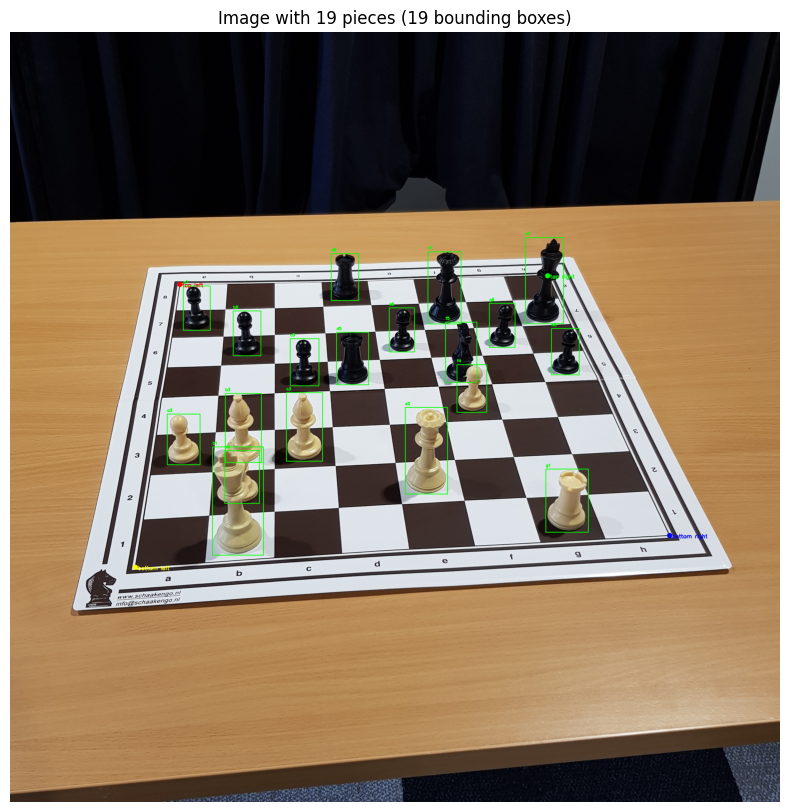

Image 1309 from /kaggle/input/chessred/chessred2k/images/91/G091_IMG070.jpg
Number of pieces: 19
Number of bounding boxes: 19
Chessboard corners:
  bottom_right: [2590.42, 1977.19]
  top_right: [2111.76, 957.33]
  bottom_left: [492.3, 2102.7]
  top_left: [667.37, 991.0]
First annotation: {'bbox': [1261.45, 870.91, 108.46, 184.93], 'category_id': 7, 'position': 'd8'}


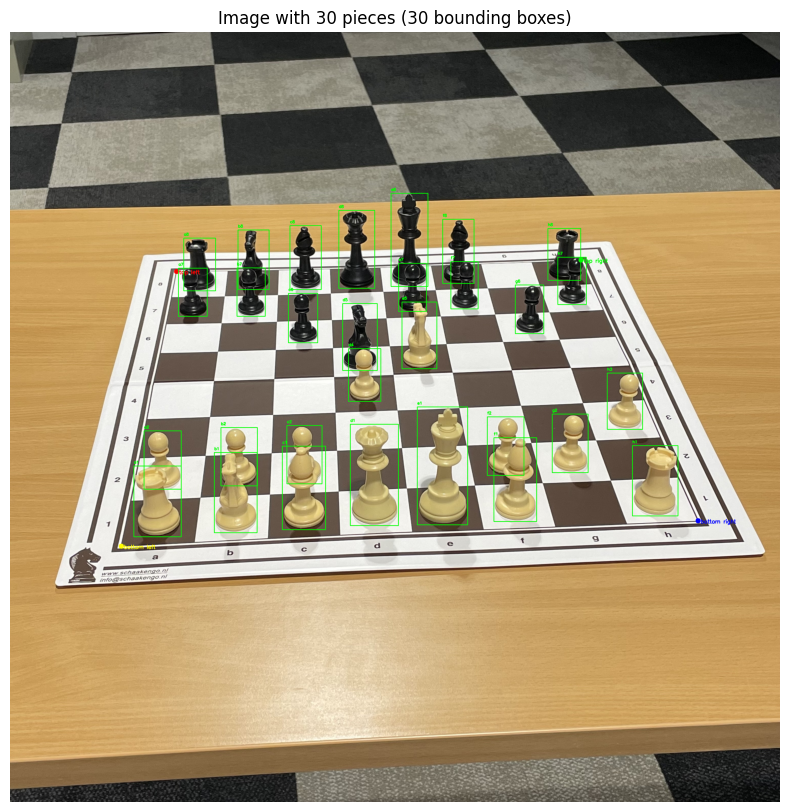

Image 228 from /kaggle/input/chessred/chessred2k/images/28/G028_IMG012.jpg
Number of pieces: 30
Number of bounding boxes: 30
Chessboard corners:
  bottom_left: [437.3, 2019.32]
  top_right: [2242.39, 895.62]
  bottom_right: [2702.31, 1919.17]
  top_left: [654.56, 940.59]
First annotation: {'bbox': [682.59, 809.82, 125.62, 207.03], 'category_id': 7, 'position': 'a8'}


In [4]:
def visualize_sample_with_bboxes(dataset, num_samples=3):
    """
    Visualize samples from the dataset with bounding boxes and chessboard corners
    """
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        img, count, annotations, corners, (h, w), img_path = dataset[idx]
        
        # Skip if it's a placeholder
        if h == 0 or w == 0:
            print(f"Skipping image {idx} (placeholder/error)")
            continue
            
        # Create a copy for drawing
        img_display = img.copy()
        
        # Draw chessboard corners if available
        if corners:
            # Define corner colors
            corner_colors = {
                'top_left': (255, 0, 0),
                'top_right': (0, 255, 0),
                'bottom_right': (0, 0, 255),
                'bottom_left': (255, 255, 0)
            }
            
            # Draw each corner as a circle with label
            for corner_name, coords in corners.items():
                x, y = int(coords[0]), int(coords[1])
                color = corner_colors.get(corner_name, (255, 255, 255))
                
                # Draw circle at corner position
                cv2.circle(img_display, (x, y), 10, color, -1)
                
                # Draw corner name
                cv2.putText(img_display, corner_name.replace('_', ' '), 
                           (x + 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # Draw bounding boxes on the image
        for i, ann in enumerate(annotations):
            bbox = ann['bbox']
            x, y, width, height = [int(v) for v in bbox]
            
            # Get category if available
            cat_id = ann.get('category_id', 0)
            cat_name = dataset.category_map.get(cat_id, f"Class {cat_id}")
            
            # Draw rectangle and label
            cv2.rectangle(img_display, (x, y), (x + width, y + height), (0, 255, 0), 2)
            cv2.putText(img_display, ann['position'], (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display the image
        plt.figure(figsize=(12, 10))
        plt.imshow(img_display)
        plt.title(f"Image with {count} pieces ({len(annotations)} bounding boxes)")
        plt.axis('off')
        plt.show()
        
        # Print annotations
        print(f"Image {idx} from {img_path}")
        print(f"Number of pieces: {count}")
        print(f"Number of bounding boxes: {len(annotations)}")
        
        # Print corner information
        if corners:
            print("Chessboard corners:")
            for corner_name, coords in corners.items():
                print(f"  {corner_name}: {coords}")

        if annotations:
            print("First annotation:", annotations[0])

# Visualize samples from the training set
print("\nVisualizing samples with bounding boxes:")
visualize_sample_with_bboxes(train_dataset, num_samples=2)

In [5]:
def prepare_yolo_dataset_with_corners(dataset_dict, output_dir='yolo_chess_dataset_with_corners'):
    """
    Prepare dataset in YOLO format with both piece and corner annotations in a single model
    
    Args:
        dataset_dict: Dictionary mapping split names to datasets
        output_dir: Directory to save the YOLO format dataset
    
    Returns:
        Path to the YOLO data.yaml file
    """
    print("Preparing YOLO dataset with both pieces and corners...")
    
    # Create necessary directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
    
    # Map our split names to YOLO's expected names
    split_mapping = {'train': 'train', 'valid': 'val', 'test': 'test'}
    
    # Get first dataset to extract category information
    first_dataset = next(iter(dataset_dict.values()))
    
    # Check all unique category IDs in the dataset
    all_category_ids = set()
    for _, dataset in dataset_dict.items():
        for i in range(len(dataset)):
            _, _, annotations, _, _, _ = dataset[i]
            for ann in annotations:
                if 'category_id' in ann:
                    all_category_ids.add(ann['category_id'])
    
    # Sort category IDs
    sorted_category_ids = sorted(list(all_category_ids))
    print(f"Found {len(sorted_category_ids)} unique piece category IDs: {sorted_category_ids}")
    
    # Create mapping from original category ID to sequential YOLO class ID
    category_id_to_yolo_id = {cat_id: i for i, cat_id in enumerate(sorted_category_ids)}
    
    # Map category IDs to names for pieces
    category_names = []
    for cat_id in sorted_category_ids:
        if cat_id in first_dataset.category_map:
            category_names.append(first_dataset.category_map[cat_id])
        else:
            category_names.append(f"class_{cat_id}")
    
    # Add corner categories with their own class IDs
    corner_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_name_to_yolo_id = {name: len(category_names) + i for i, name in enumerate(corner_names)}
    
    # Add corner names to the category list
    category_names.extend(corner_names)
    
    print(f"Category mapping:")
    for cat_id, yolo_id in category_id_to_yolo_id.items():
        name = first_dataset.category_map.get(cat_id, f"class_{cat_id}")
        print(f"  Piece ID: {cat_id} -> YOLO ID: {yolo_id} ({name})")
    
    for corner_name, yolo_id in corner_name_to_yolo_id.items():
        print(f"  Corner: {corner_name} -> YOLO ID: {yolo_id}")
    
    # Process each split
    for split_name, dataset in dataset_dict.items():
        yolo_split = split_mapping.get(split_name, split_name)
        print(f"Processing {split_name} split with {len(dataset)} images...")
        
        # Process each image in the split
        for i in tqdm(range(len(dataset))):
            img, count, annotations, corners, (h, w), img_path = dataset[i]
            
            # Skip images without annotations, dimensions or corners
            if h == 0 or w == 0 or not annotations or not corners:
                continue
                
            # Save image with a unique filename
            img_filename = f"{split_name}_{i:06d}.jpg"
            img_output_path = os.path.join(output_dir, 'images', yolo_split, img_filename)
            
            if isinstance(img, np.ndarray):
                cv2.imwrite(img_output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
            # Create YOLO format labels
            label_path = os.path.join(output_dir, 'labels', yolo_split, f"{split_name}_{i:06d}.txt")
            with open(label_path, 'w') as f:
                # First write the piece annotations
                for ann in annotations:
                    # Get bounding box
                    bbox = ann['bbox']
                    x, y, width, height = bbox
                    
                    # Convert to YOLO format: class_id, x_center, y_center, width, height (normalized)
                    original_category_id = ann['category_id']
                    yolo_class_id = category_id_to_yolo_id.get(original_category_id, 0)  # Default to 0 if not found
                    
                    x_center = (x + width/2) / w
                    y_center = (y + height/2) / h
                    width_norm = width / w
                    height_norm = height / h
                    
                    # Write to file
                    f.write(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
                
                # For corners, create small bounding boxes around each point
                corner_size = 0.02  # Size of corner box (2% of image width/height)
                for corner_name, coords in corners.items():
                    x, y = coords
                    
                    # Normalize coordinates
                    x_norm = x / w
                    y_norm = y / h
                    
                    # Get YOLO class ID for this corner
                    yolo_class_id = corner_name_to_yolo_id[corner_name]
                    
                    # Write to file
                    f.write(f"{yolo_class_id} {x_norm:.6f} {y_norm:.6f} {corner_size:.6f} {corner_size:.6f}\n")
    
    # Create YAML configuration file
    data_yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(data_yaml_path, 'w') as f:
        f.write(f"train: {os.path.join('images', 'train')}\n")
        f.write(f"val: {os.path.join('images', 'val')}\n")
        f.write(f"test: {os.path.join('images', 'test')}\n")
        
        # Write number of classes and names
        f.write(f"nc: {len(category_names)}\n")
        
        # Write class names in proper format
        category_str = "["
        for i, name in enumerate(category_names):
            if i > 0:
                category_str += ", "
            category_str += f"'{name}'"
        category_str += "]"
        f.write(f"names: {category_str}\n")
    
    print(f"YOLO dataset prepared at {output_dir}")
    print(f"Configuration file: {data_yaml_path}")
    print(f"Using {len(category_names)} categories ({len(sorted_category_ids)} pieces + 4 corners)")
    
    return data_yaml_path

# Prepare the combined dataset
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
}
data_yaml = prepare_yolo_dataset_with_corners(datasets)

Preparing YOLO dataset with both pieces and corners...
Found 12 unique piece category IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Category mapping:
  Piece ID: 0 -> YOLO ID: 0 (white-pawn)
  Piece ID: 1 -> YOLO ID: 1 (white-rook)
  Piece ID: 2 -> YOLO ID: 2 (white-knight)
  Piece ID: 3 -> YOLO ID: 3 (white-bishop)
  Piece ID: 4 -> YOLO ID: 4 (white-queen)
  Piece ID: 5 -> YOLO ID: 5 (white-king)
  Piece ID: 6 -> YOLO ID: 6 (black-pawn)
  Piece ID: 7 -> YOLO ID: 7 (black-rook)
  Piece ID: 8 -> YOLO ID: 8 (black-knight)
  Piece ID: 9 -> YOLO ID: 9 (black-bishop)
  Piece ID: 10 -> YOLO ID: 10 (black-queen)
  Piece ID: 11 -> YOLO ID: 11 (black-king)
  Corner: top_left -> YOLO ID: 12
  Corner: top_right -> YOLO ID: 13
  Corner: bottom_right -> YOLO ID: 14
  Corner: bottom_left -> YOLO ID: 15
Processing train split with 1442 images...


100%|██████████| 1442/1442 [02:31<00:00,  9.51it/s]


Processing valid split with 330 images...


100%|██████████| 330/330 [00:35<00:00,  9.39it/s]


Processing test split with 306 images...


100%|██████████| 306/306 [00:32<00:00,  9.43it/s]

YOLO dataset prepared at yolo_chess_dataset_with_corners
Configuration file: yolo_chess_dataset_with_corners/data.yaml
Using 16 categories (12 pieces + 4 corners)


In [6]:
def train_yolo_model(data_yaml, model_size='m', epochs=20):
    """
    Train YOLO11 model using the prepared dataset with real bounding boxes
    
    Args:
        data_yaml: Path to data.yaml file
        model_size: YOLO model size ('n', 's', 'm', 'l', 'x')
        epochs: Number of epochs to train
        
    Returns:
        Path to the best model weights
    """
    print(f"Training YOLO11-{model_size} model on dataset with real bounding boxes...")
    print(f"Training will run for {epochs} epochs")
    
    # Initialize model
    model = YOLO(f'yolo11{model_size}.pt')  # Load pretrained model
    
    # Set training parameters
    training_args = {
        'data': data_yaml,          # Path to dataset config
        'epochs': epochs,           # Number of epochs
        'imgsz': 640,               # Image size
        'batch': 16,                # Batch size
        'patience': 0,              # Early stopping patience
        'name': f'chess_detector_real_bbox_{model_size}',  # Run name
        'project': 'runs/detect',   # Project directory
        'device': 0 if device == 'cuda' else 'cpu',  # Device to use
        'verbose': True,            # Verbose output
        'exist_ok': True            # Overwrite existing output
    }
    
    # Train the model
    try:
        results = model.train(**training_args)
        
        # Get the best model path
        best_model_path = f'runs/detect/chess_detector_real_bbox_{model_size}/weights/best.pt'
        if os.path.exists(best_model_path):
            print(f"Training completed successfully.")
            print(f"Best model saved to: {best_model_path}")
            return best_model_path
        else:
            print(f"Training completed, but best model not found at expected path.")
            return None
            
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None

# Train the model
model_path = train_yolo_model(data_yaml, model_size='m', epochs=1)

Training YOLO11-m model on dataset with real bounding boxes...
Training will run for 1 epochs


100%|██████████| 38.8M/38.8M [00:00<00:00, 64.7MB/s]


Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_chess_dataset_with_corners/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_detector_real_bbox_m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=0, perspective

100%|██████████| 755k/755k [00:00<00:00, 4.13MB/s]


Overriding model.yaml nc=80 with nc=16

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2897.3±2070.1 MB/s, size: 2182.0 KB)


train: Scanning /kaggle/working/yolo_chess_dataset_with_corners/labels/train... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<00:00, 1443.54it/s]


train: New cache created: /kaggle/working/yolo_chess_dataset_with_corners/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2003.8±1927.5 MB/s, size: 1870.3 KB)


val: Scanning /kaggle/working/yolo_chess_dataset_with_corners/labels/val... 330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 330/330 [00:00<00:00, 618.15it/s]

val: New cache created: /kaggle/working/yolo_chess_dataset_with_corners/labels/val.cache


Plotting labels to runs/detect/chess_detector_real_bbox_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/chess_detector_real_bbox_m
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      8.53G     0.6905      1.523     0.8664        107        640: 100%|██████████| 91/91 [01:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


                   all        330       7452       0.81      0.866      0.849      0.639


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



1 epochs completed in 0.026 hours.
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/chess_detector_real_bbox_m/weights/best.pt, 40.5MB

Validating runs/detect/chess_detector_real_bbox_m/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 125 layers, 20,042,368 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


                   all        330       7452      0.809      0.866      0.849      0.639
            white-pawn        330       1625      0.993      0.988      0.995      0.784
            white-rook        281        447      0.991      0.996      0.995      0.792
          white-knight        220        274      0.989      0.996      0.995      0.792
          white-bishop        235        335          1      0.945      0.994      0.797
           white-queen        126        126      0.901      0.992      0.993      0.858
            white-king        330        330      0.896      0.988      0.993       0.85
            black-pawn        330       1511      0.999      0.984      0.995      0.783
            black-rook        280        471      0.998      0.986      0.995       0.81
          black-knight        125        178      0.954      0.961       0.99      0.761
          black-bishop        223        380      0.944      0.958      0.987      0.799
           black-quee

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 12.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/chess_detector_real_bbox_m
Training completed successfully.
Best model saved to: runs/detect/chess_detector_real_bbox_m/weights/best.pt


Evaluating model from runs/detect/chess_detector_real_bbox_m/weights/best.pt on test data...
Corner class indices: [12, 13, 14, 15]


Evaluating: 100%|██████████| 306/306 [00:29<00:00, 10.42it/s, MAE=2.2200]



Test Results:
Mean Absolute Error (MAE): 2.2059
Root Mean Square Error (RMSE): 3.1854

Classification Metrics:
Accuracy: 0.2124 (65/306)
F1 Score: 0.9434
Recall: 0.8932
MAE for 6-10 pieces: 0.5102 (n=49)
MAE for 11-15 pieces: 1.8889 (n=63)
MAE for 16-20 pieces: 1.4231 (n=52)
MAE for 21-32 pieces: 3.2183 (n=142)


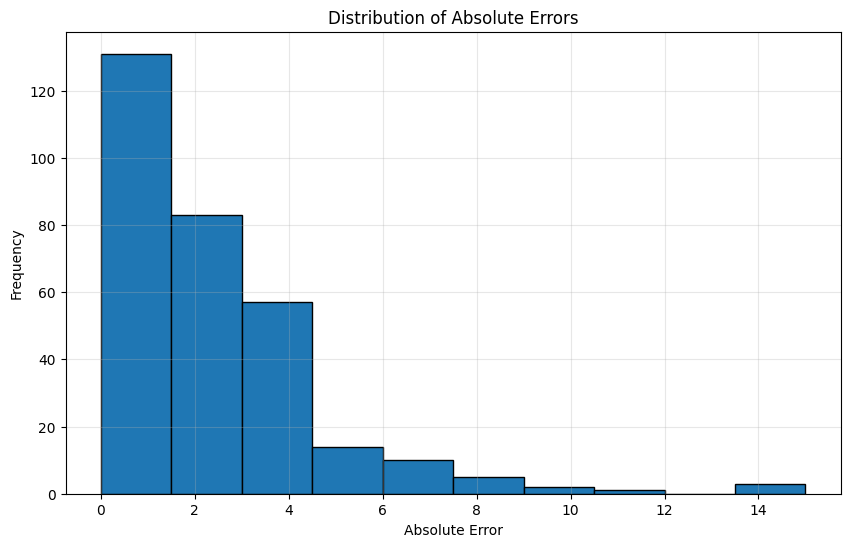

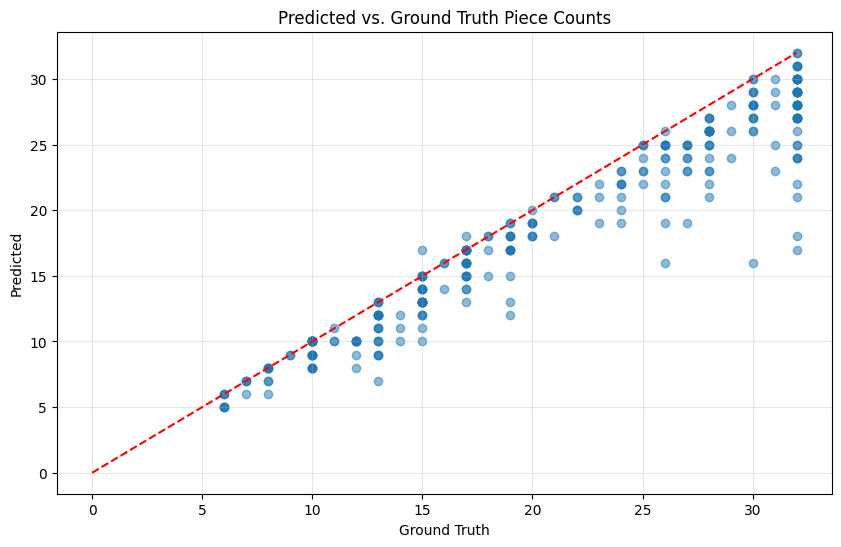

In [7]:
def evaluate_model(model_path, test_dataset):
    """
    Evaluate the trained YOLO model on the test dataset
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset with bounding box annotations
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    print(f"Evaluating model from {model_path} on test data...")
    
    # Load the model
    model = YOLO(model_path)
    
    # Get the class names from the model
    class_names = model.names
    
    # Find corner classes in the model's class names
    corner_class_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_indices = [idx for idx, name in class_names.items() if name in corner_class_names]
    
    print(f"Corner class indices: {corner_indices}")
    
    # Initialize metrics
    results = {
        'predictions': [],
        'ground_truth': [],
        'absolute_errors': [],
        'squared_errors': [],
        'correct_count': 0,
    }
    
    # Create test dataloader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Create a progress bar
    progress_bar = tqdm(total=len(test_loader), desc="Evaluating")
    
    # Process each test image
    for i, (img, gt_count, annotations, corners, dims, img_path) in enumerate(test_loader):
        # Get image
        if isinstance(img, list):
            img = img[0]
        elif isinstance(img, torch.Tensor):
            img = img.numpy()[0]
            
        # Get ground truth count
        gt_count = int(gt_count.item())
        
        # Skip invalid images
        if img.size == 0 or dims[0].item() == 0:
            continue
            
        # Run inference
        detection_results = model(img, conf=0.70, verbose=False)
        
        # Get all detections
        boxes = detection_results[0].boxes
        
        # Separate piece and corner detections
        piece_boxes = boxes[~np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        
        # Count pieces only (not corners)
        pred_count = len(piece_boxes)
        
        # Count exact matches
        if pred_count == gt_count:
            results['correct_count'] += 1
            
        # Store results
        results['predictions'].append(pred_count)
        results['ground_truth'].append(gt_count)
        results['absolute_errors'].append(abs(pred_count - gt_count))
        results['squared_errors'].append((pred_count - gt_count) ** 2)
        
        # Update progress bar
        progress_bar.update(1)
        
        # Print progress every 50 images with simple output
        if (i + 1) % 50 == 0:
            current_mae = np.mean(results['absolute_errors'][:i+1])
            progress_bar.set_postfix({"MAE": f"{current_mae:.4f}"})
    
    # Close progress bar
    progress_bar.close()
    
    # Calculate final metrics
    mae = np.mean(results['absolute_errors'])
    mse = np.mean(results['squared_errors'])
    rmse = np.sqrt(mse)
    
    # Calculate classification metrics
    total_images = len(results['predictions'])
    accuracy = results['correct_count'] / total_images
    
    # Calculate TP, FP, FN for F1 and recall
    tp = sum(min(p, g) for p, g in zip(results['predictions'], results['ground_truth']))
    fp = sum(max(0, p - g) for p, g in zip(results['predictions'], results['ground_truth']))
    fn = sum(max(0, g - p) for p, g in zip(results['predictions'], results['ground_truth']))
    
    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nTest Results:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    
    print("\nClassification Metrics:")
    print(f"Accuracy: {accuracy:.4f} ({results['correct_count']}/{total_images})")  
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Break down results by number of pieces
    ranges = [(6, 10), (11, 15), (16, 20), (21, 32)]
    for low, high in ranges:
        # Get indices of images with piece count in this range
        indices = [i for i, c in enumerate(results['ground_truth']) if low <= c <= high]
        
        if indices:
            range_abs_errors = [results['absolute_errors'][i] for i in indices]
            range_mae = np.mean(range_abs_errors)
            print(f"MAE for {low}-{high} pieces: {range_mae:.4f} (n={len(indices)})")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(results['absolute_errors'], bins=10, edgecolor='black')
    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.scatter(results['ground_truth'], results['predictions'], alpha=0.5)
    
    # Add perfect prediction line
    max_val = max(max(results['ground_truth']), max(results['predictions']))
    plt.plot([0, max_val], [0, max_val], 'r--')
    
    plt.title('Predicted vs. Ground Truth Piece Counts')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Evaluate the model
if model_path and os.path.exists(model_path):
    evaluation_results = evaluate_model(model_path, test_dataset)
else:
    print("No model available for evaluation. Please train the model first.")


Visualizing piece and corner predictions:

--- Image 298 ---
Path: /kaggle/input/chessred/chessred2k/images/76/G076_IMG092.jpg
Actual piece count: 13
Number of ground truth bounding boxes: 13

0: 640x640 5 white-pawns, 1 white-rook, 1 white-king, 4 black-pawns, 1 black-rook, 1 black-king, 17.6ms
Speed: 3.5ms preprocess, 17.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 13
Error: 0
Detected 0 of 4 corners
Ground truth corners:
  bottom_left: [2513.39, 1797.01]
  bottom_right: [1987.68, 812.68]
  top_right: [627.93, 954.08]
  top_left: [673.0, 2070.0]


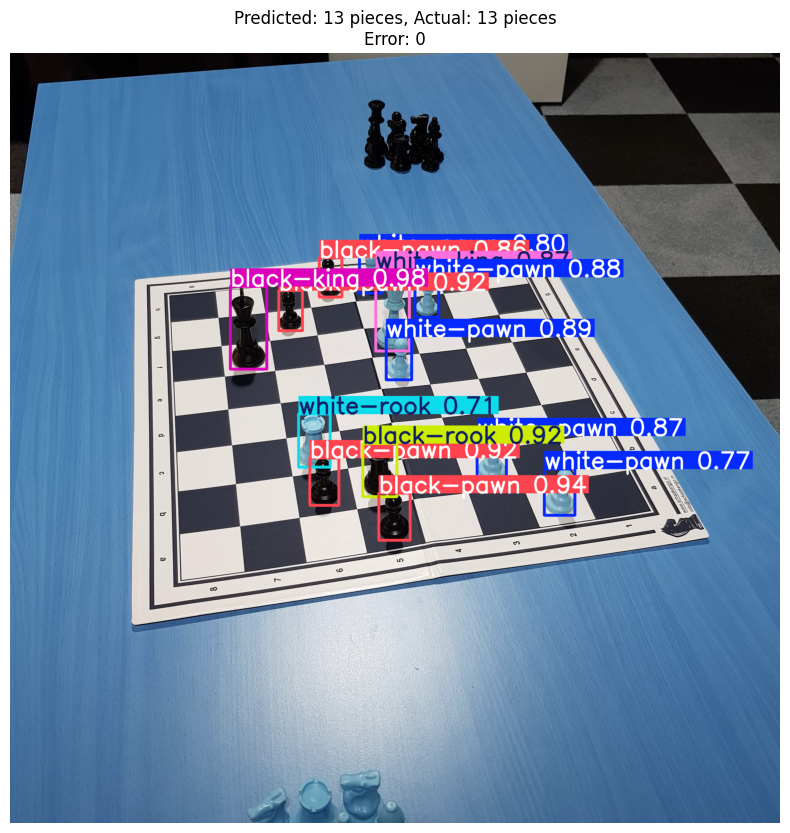


--- Image 111 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG008.jpg
Actual piece count: 32
Number of ground truth bounding boxes: 32

0: 640x640 8 white-pawns, 1 white-rook, 1 white-knight, 2 white-bishops, 1 white-queen, 7 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-king, 17.7ms
Speed: 3.7ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 27
Error: 5
Detected 0 of 4 corners
Ground truth corners:
  top_right: [2581.25, 1693.34]
  top_left: [1740.18, 946.87]
  bottom_left: [475.11, 1293.55]
  bottom_right: [1112.22, 2236.06]


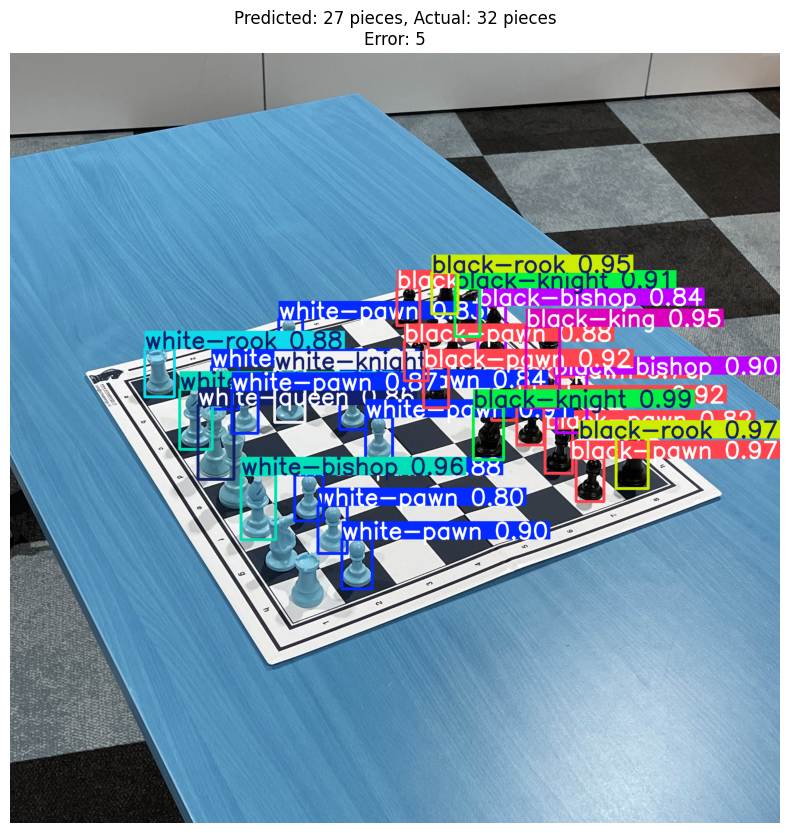


--- Image 258 ---
Path: /kaggle/input/chessred/chessred2k/images/76/G076_IMG052.jpg
Actual piece count: 19
Number of ground truth bounding boxes: 19

0: 640x640 5 white-pawns, 1 white-rook, 1 white-bishop, 1 white-queen, 1 white-king, 5 black-pawns, 1 black-rook, 1 black-bishop, 1 black-queen, 1 black-king, 1 bottom_left, 17.7ms
Speed: 3.7ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 18
Error: 1
Detected 1 of 4 corners
Ground truth corners:
  bottom_left: [2530.04, 1127.57]
  bottom_right: [1127.34, 881.52]
  top_left: [2192.32, 2283.87]
  top_right: [445.82, 1867.7]
Predicted corners:
  bottom_left: Position (2534.9, 1123.2), Confidence: 0.80


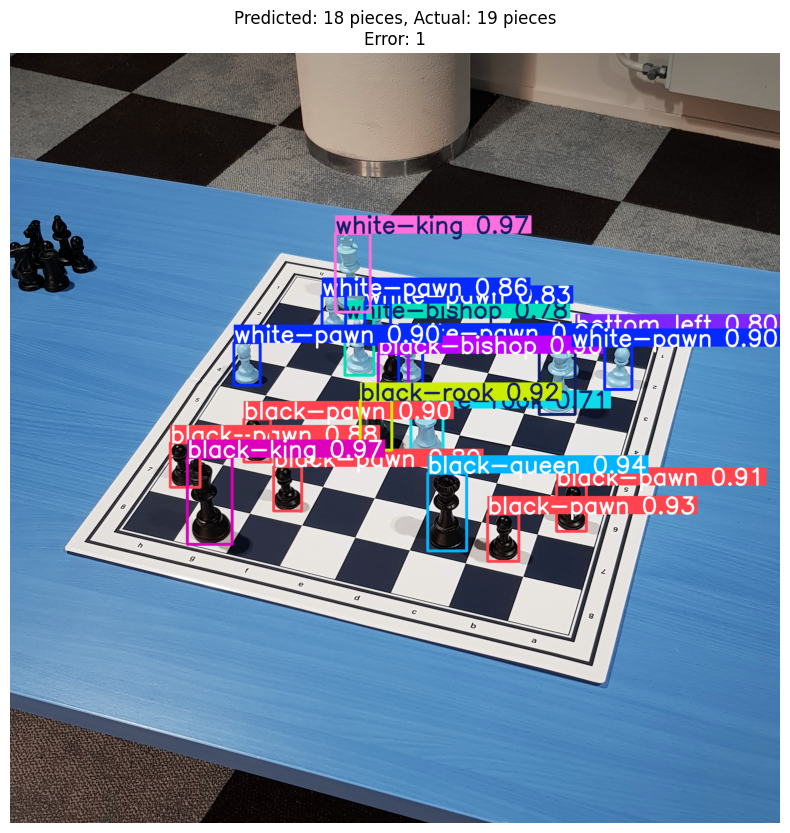


--- Image 71 ---
Path: /kaggle/input/chessred/chessred2k/images/0/G000_IMG071.jpg
Actual piece count: 15
Number of ground truth bounding boxes: 15

0: 640x640 3 white-pawns, 2 white-rooks, 1 white-knight, 1 white-bishop, 1 white-king, 3 black-pawns, 2 black-rooks, 1 black-knight, 1 black-king, 17.7ms
Speed: 3.5ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 15
Error: 0
Detected 0 of 4 corners
Ground truth corners:
  bottom_right: [2283.38, 704.82]
  bottom_left: [2495.15, 1656.91]
  top_left: [525.87, 1679.04]
  top_right: [800.7, 744.72]


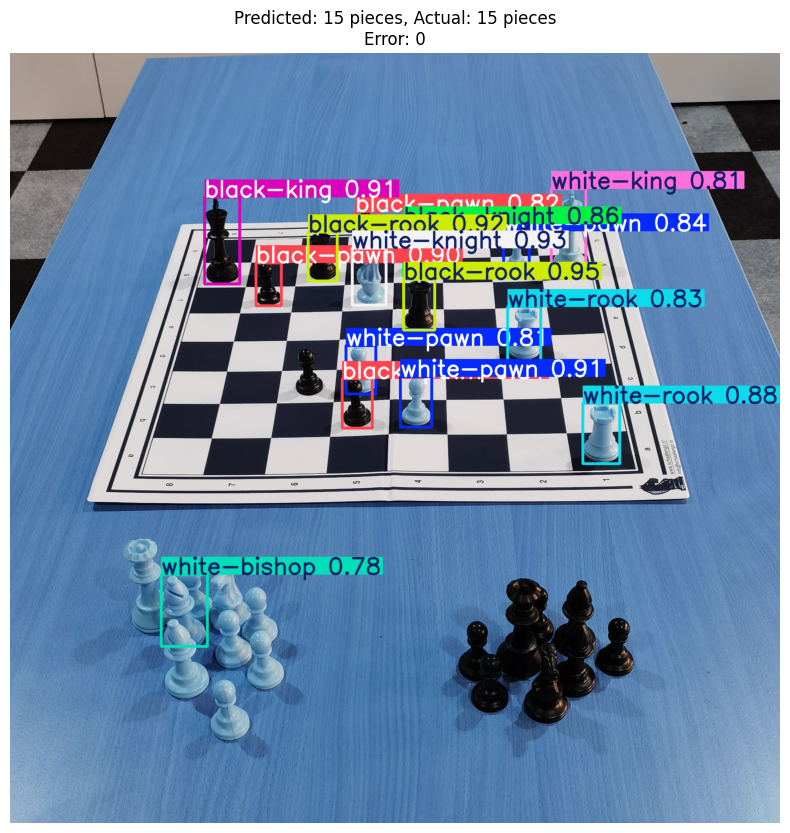


--- Image 144 ---
Path: /kaggle/input/chessred/chessred2k/images/33/G033_IMG041.jpg
Actual piece count: 25
Number of ground truth bounding boxes: 25

0: 640x640 5 white-pawns, 2 white-rooks, 1 white-knight, 2 white-bishops, 1 white-queen, 1 white-king, 6 black-pawns, 2 black-rooks, 1 black-knight, 1 black-bishop, 1 black-king, 17.7ms
Speed: 3.8ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted piece count: 23
Error: 2
Detected 0 of 4 corners
Ground truth corners:
  bottom_right: [2329.58, 939.5]
  top_right: [947.61, 775.8]
  bottom_left: [2283.99, 2092.52]
  top_left: [427.46, 1796.86]


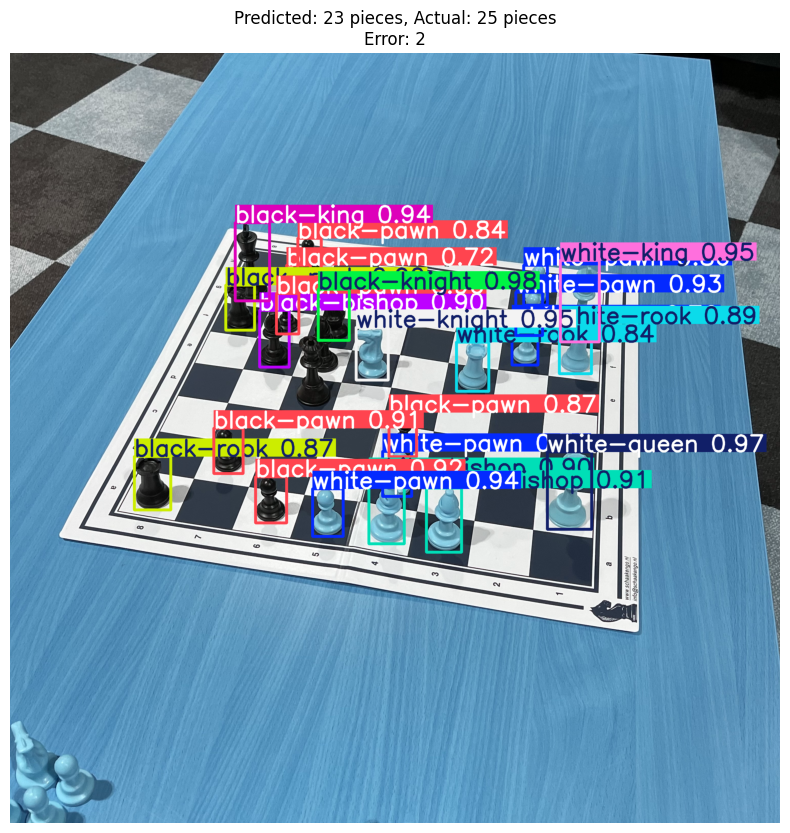

In [8]:
def visualize_piece_and_corner_predictions(model_path, test_dataset, num_samples=5):
    """
    Visualize model predictions for both chess pieces and board corners
    
    Args:
        model_path: Path to the trained model
        test_dataset: Test dataset
        num_samples: Number of samples to visualize
    """
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return
        
    # Load the model
    model = YOLO(model_path)
    
    # Get the class names from the model
    class_names = model.names
    
    # Find corner classes in the model's class names
    corner_class_names = ["top_left", "top_right", "bottom_right", "bottom_left"]
    corner_indices = [idx for idx, name in class_names.items() if name in corner_class_names]
    
    # Randomly sample images
    indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))
    
    for idx in indices:
        # Get sample
        img, gt_count, annotations, gt_corners, (h, w), img_path = test_dataset[idx]
        
        # Skip invalid images
        if h == 0 or w == 0:
            continue
            
        print(f"\n--- Image {idx} ---")
        print(f"Path: {img_path}")
        print(f"Actual piece count: {gt_count}")
        print(f"Number of ground truth bounding boxes: {len(annotations)}")
        
        # Run inference
        results = model(img, conf=0.70)
        
        # Get all detections
        boxes = results[0].boxes
        
        # Separate piece and corner detections
        piece_boxes = boxes[~np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        corner_boxes = boxes[np.isin(boxes.cls.cpu().numpy(), corner_indices)]
        
        # Count pieces
        pred_count = len(piece_boxes)
        
        print(f"Predicted piece count: {pred_count}")
        print(f"Error: {abs(pred_count - gt_count)}")
        print(f"Detected {len(corner_boxes)} of 4 corners")
        
        # Make a copy of the image for drawing
        img_display = img.copy() if isinstance(img, np.ndarray) else img
        
        # Plot all detections
        annotated_img = results[0].plot()
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        # Print ground truth corners without drawing them
        if gt_corners:
            print("Ground truth corners:")
            for corner_name, coords in gt_corners.items():
                print(f"  {corner_name}: {coords}")
        
        # Print predicted corners
        if len(corner_boxes) > 0:
            print("Predicted corners:")
            for box in corner_boxes:
                cls_id = int(box.cls.item())
                conf = box.conf.item()
                x, y, w, h = box.xywh.cpu().numpy()[0]
                corner_name = class_names[cls_id]
                print(f"  {corner_name}: Position ({x:.1f}, {y:.1f}), Confidence: {conf:.2f}")
        
        # Display
        plt.figure(figsize=(12, 10))
        plt.imshow(annotated_img_rgb)
        plt.title(f"Predicted: {pred_count} pieces, Actual: {gt_count} pieces\nError: {abs(pred_count - gt_count)}")
        plt.axis('off')
        plt.show()

# Visualize predictions from the combined model
if model_path and os.path.exists(model_path):
    print("\nVisualizing piece and corner predictions:")
    visualize_piece_and_corner_predictions(model_path, test_dataset, num_samples=5)
else:
    print("No model available for visualization. Please train the model first.")